In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from models.lstm import LSTMRegressor
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np

In [5]:
stock = StockIndex.NVDA
window_size = 7

best_params_nvda = {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.13975394427415688, 'lr': 0.00204355398440737, 'batch_size': 16}


device = "cuda" if torch.cuda.is_available() else "cpu"

16


In [6]:
train_dl, test_dl, scalers = get_data_loaders(
    stock, window_size, batch_size=best_params_nvda['batch_size'], use_val_split=False
)
input_dim = next(iter(train_dl))[0].shape[-1]


Epoch 1: Train=0.0086
Epoch 2: Train=0.0010
Epoch 3: Train=0.0010
Epoch 4: Train=0.0012
Epoch 5: Train=0.0007
Epoch 6: Train=0.0008
Epoch 7: Train=0.0007
Epoch 8: Train=0.0005
Epoch 9: Train=0.0007
Epoch 10: Train=0.0007
Epoch 11: Train=0.0007
Epoch 12: Train=0.0006
Epoch 13: Train=0.0006
Epoch 14: Train=0.0004
Epoch 15: Train=0.0005
Epoch 16: Train=0.0005
Epoch 17: Train=0.0004
Epoch 18: Train=0.0005
Epoch 19: Train=0.0005
Epoch 20: Train=0.0005
Epoch 21: Train=0.0005
Epoch 22: Train=0.0004
Epoch 23: Train=0.0004
Epoch 24: Train=0.0004
Epoch 25: Train=0.0005
Epoch 26: Train=0.0005
Epoch 27: Train=0.0005
Epoch 28: Train=0.0005
Epoch 29: Train=0.0004
Epoch 30: Train=0.0004
Epoch 31: Train=0.0005
Epoch 32: Train=0.0004
Epoch 33: Train=0.0004
Epoch 34: Train=0.0004
Epoch 35: Train=0.0004
Epoch 36: Train=0.0005
Epoch 37: Train=0.0004
Epoch 38: Train=0.0004
Epoch 39: Train=0.0004
Epoch 40: Train=0.0004
Epoch 41: Train=0.0005
Epoch 42: Train=0.0006
Epoch 43: Train=0.0005
Epoch 44: Train=0.00

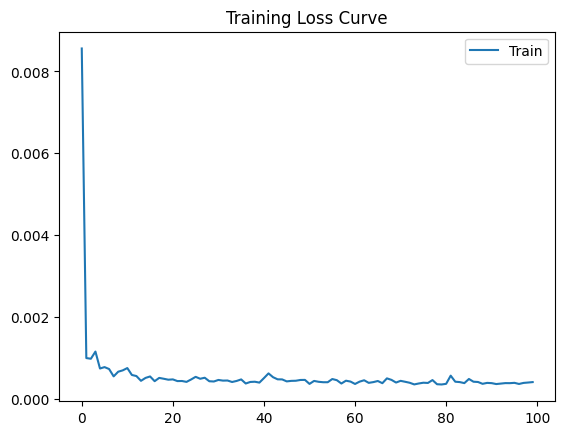

In [8]:
model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=best_params_nvda['hidden_dim'],
    num_layers=best_params_nvda['num_layers'],
    dropout=best_params_nvda['dropout']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params_nvda['lr'])
criterion = nn.MSELoss()

train_losses = []

for epoch in range(100):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}: Train={train_loss}")

plt.plot(train_losses, label='Train')
plt.legend(); plt.title("Training Loss Curve"); plt.show()

Test RMSE: 26.3115
Test MAE : 21.1038


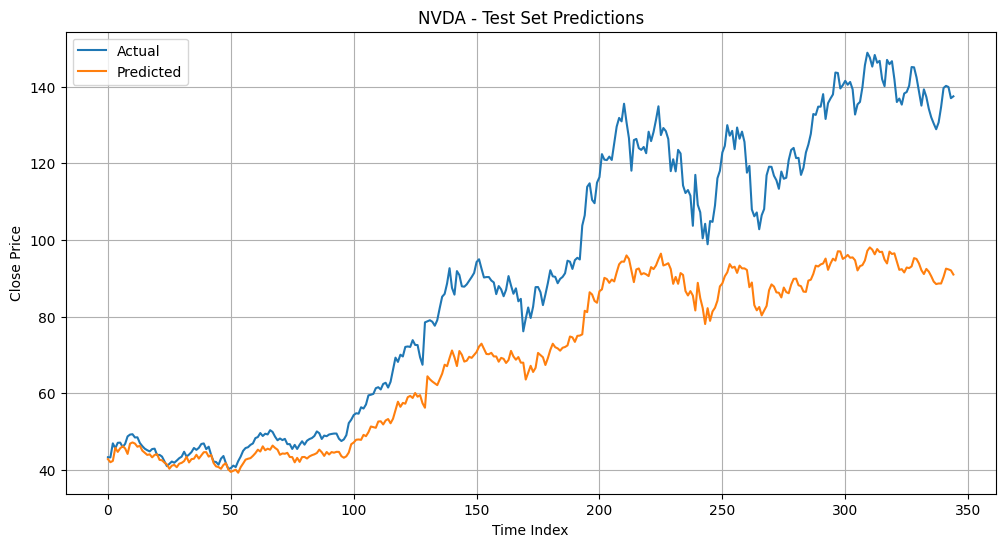

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = model(xb).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(targets_unscaled, preds_unscaled))
mae = mean_absolute_error(targets_unscaled, preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(targets_unscaled, label="Actual")
plt.plot(preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()
